In [61]:
from data_prep_utils import *
import matplotlib.pyplot as plt
from datetime import datetime
from tabpfn_new import priors, encoders
from tabpfn_new.scripts.model_configs import *
from tabpfn_new.scripts.model_builder import get_forest_prior_hyperparameters, get_mlp_prior_hyperparameters
from tabpfn.utils import get_uniform_single_eval_pos_sampler
from utils import get_dataloader

In [62]:
def reload_config(prior_type='forest', config_type='causal', task_type='binary', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'] = prior_type
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [176]:
def dl_from_config(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=0)
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return dl

                                     
def get_sample(dl):
    (style, x, y), _, _ =  next(iter(dl))
    return x, y
    
def plot_grid(dl, hyperparameters, rows=8, cols=6):
    fig, axes = plt.subplots(rows, cols, figsize=(20,15))
    generator = synthetic_dataset_generator_tabpfn(n_samples=1000, max_classes=2, min_features=2, max_features=100)
    class_assigner = priors.flexible_categorical.MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    for ax in axes.flatten():
        x2, b = get_sample(dl)
        b = class_assigner(b)
        i1, i2 = np.random.choice(x2.shape[2], size=(2,), replace=False)
        ax.scatter(x2[:, 0, i1], x2[:, 0, i2], c=b, s=1.5, cmap="bwr")

def plot_feature_combinations(dl, hyperparameters, num_plots=10):
    fig = plt.figure(figsize=(20,15))
    x2, b = get_sample(dl)
    class_assigner = priors.flexible_categorical.BalancedBinarize()#MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    b = class_assigner(b)
    n_feat = num_plots#hyperparameters["max_features"]
    for i in range(n_feat-1):
        for j in range(n_feat):
            if(j>i) :
                ax = plt.subplot2grid((n_feat-1, n_feat-1), (i,j-1))
                #ax.xaxis.set_ticklabels([]) 
                #ax.yaxis.set_ticklabels([])
                plt.scatter(x2[:,0,i],x2[:,0,j],c=b, s=1.5, cmap="bwr")
    
    fig.show()

In [180]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']

config['multiclass_type'] = 'rank'
del config['differentiable_hyperparameters']['multiclass_type']

config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = .2 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .1 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = True

    
config['aggregate_k_gradients'] = 1
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 1//config['aggregate_k_gradients']
config['epochs'] = 1

config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = True
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 20
config['num_layers'] = 2
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.Tanh
config["block_wise_dropout"] = True
config["sort_features"] = True
config["in_clique"] = True

# general data params
config['num_classes'] = 2
config['max_num_classes'] = 2
config['max_features'] = 100

config_sample = evaluate_hypers(config)
prior_hyperparameters = get_mlp_prior_hyperparameters(config_sample)
model_proto = priors.mlp



Using style prior: True


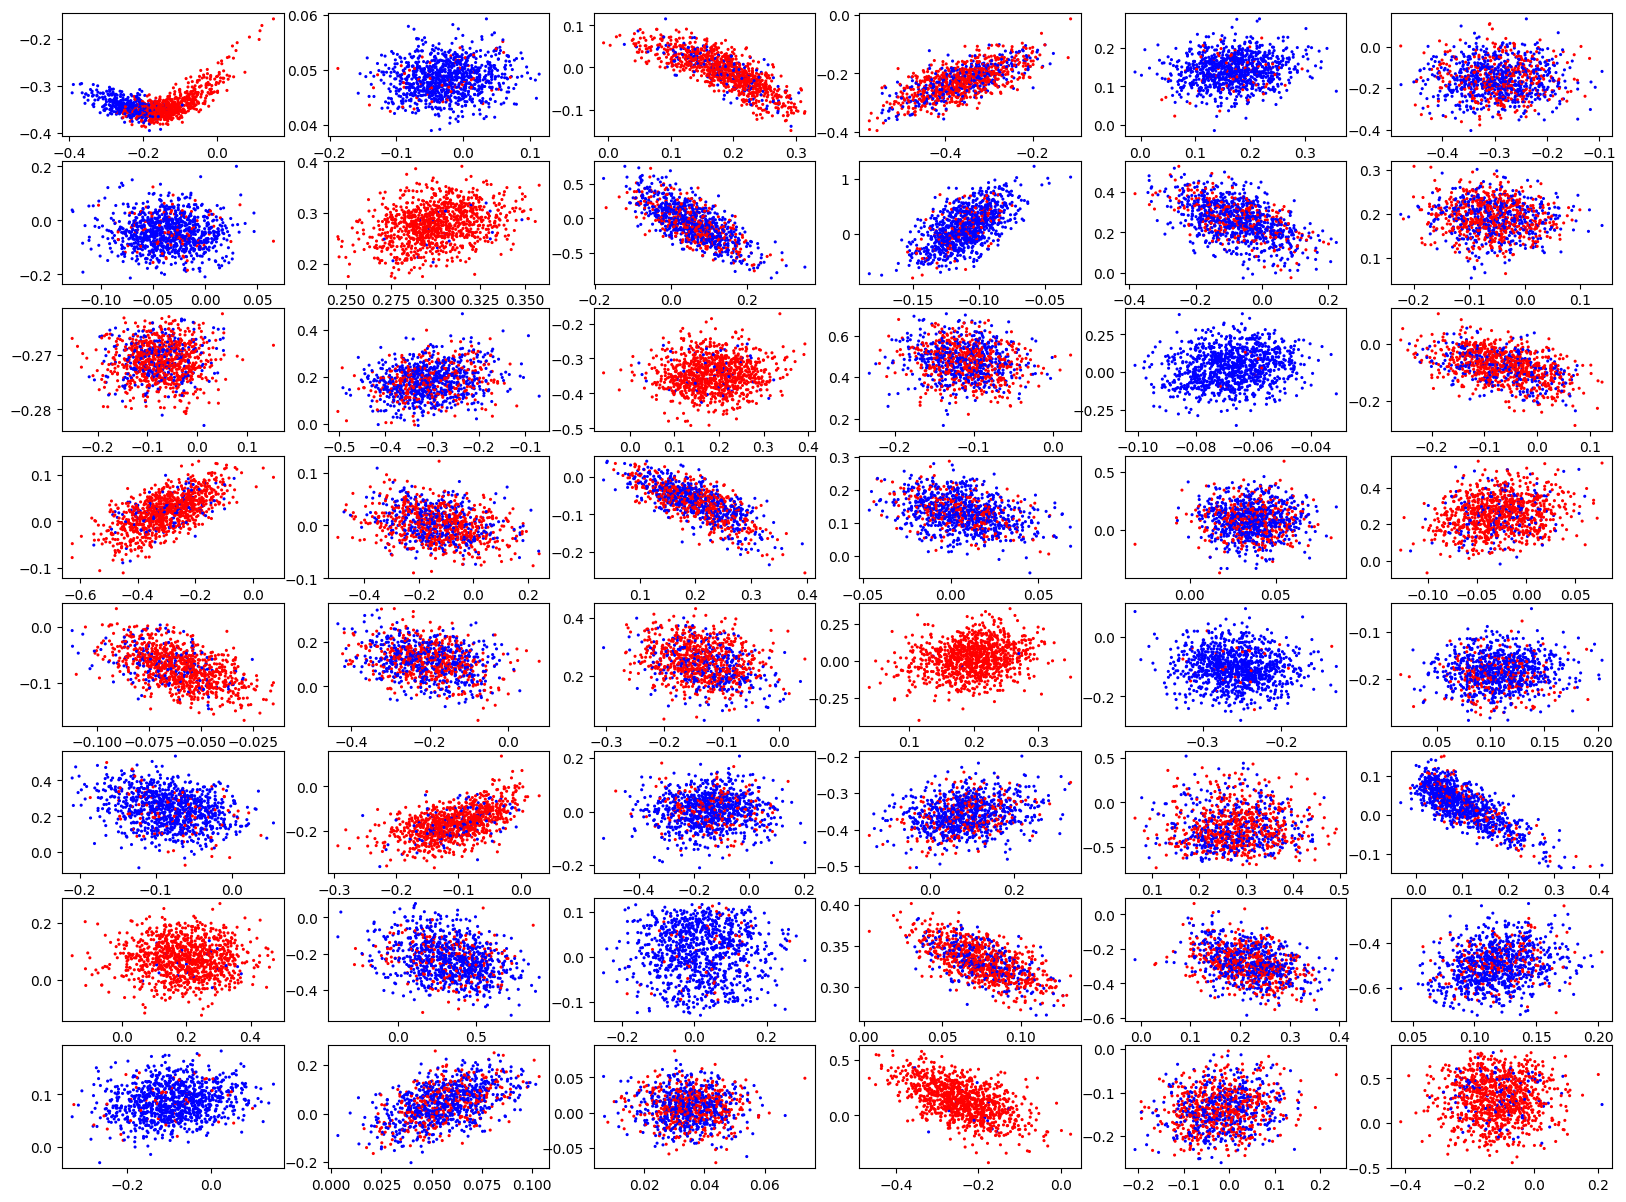

In [181]:
dl = dl_from_config(config_sample, prior_hyperparameters)
plot_grid(dl, prior_hyperparameters)
#print(get_sample(dl))

C:\Users\lenna\AppData\Local\Temp\ipykernel_5700\3706495498.py:42: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


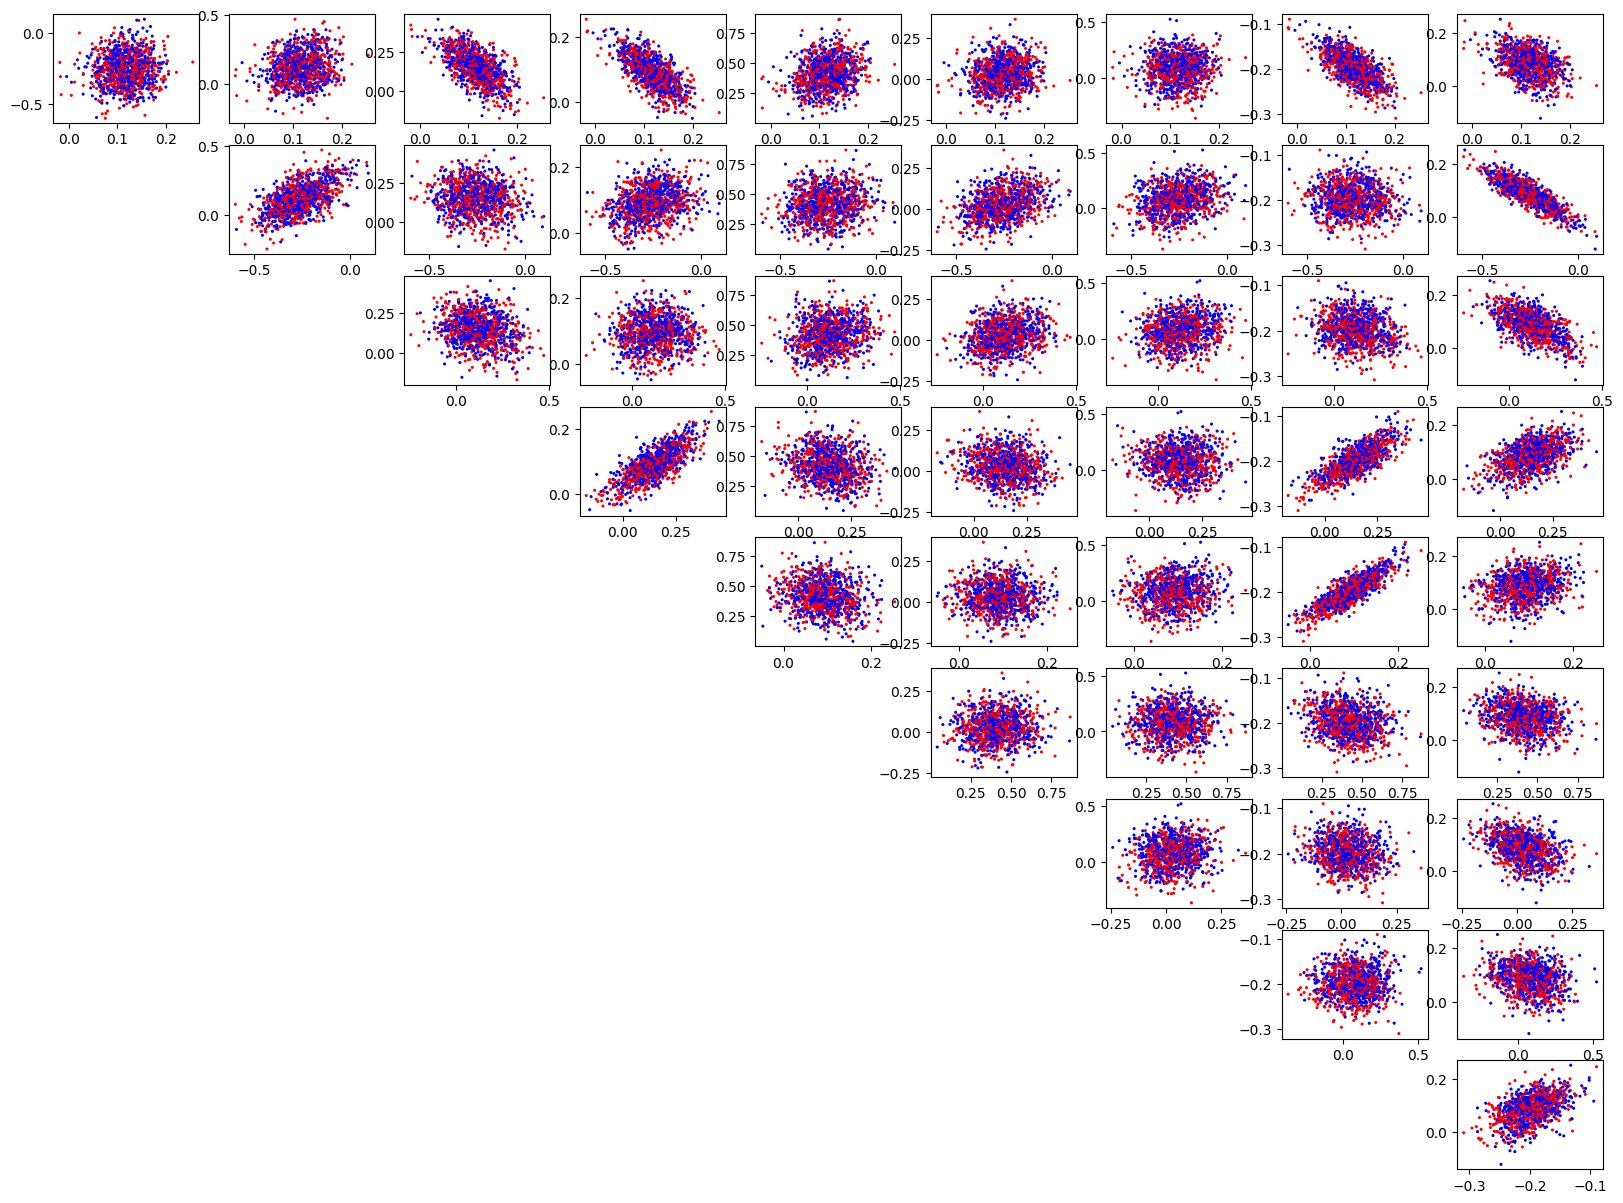

In [184]:
plot_feature_combinations(dl, prior_hyperparameters)

In [123]:
'''def get_sample(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    ''extra_prior_kwargs_dict={
        'num_features': config['num_features'], 
        'hyperparameters': prior_hyperparameters
    }
    extra_kwargs = {}
    if 'flexible' in config and config['flexible']:
        get_batch_base = make_get_batch(model_proto)
        extra_kwargs['get_batch'] = get_batch_base
        model_proto = priors.flexible_categorical
    if 'differentiable' in prior_hyperparameters and prior_hyperparameters['differentiable']:
        get_batch_base = make_get_batch(model_proto, **extra_kwargs)
        extra_kwargs = {'get_batch': get_batch_base, 'differentiable_hyperparameters': prior_hyperparameters['differentiable_hyperparameters']}
        model_proto = priors.differentiable_prior
        use_style = True
    
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_prior_kwargs_dict)''
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=2)
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return next(iter(dl))'''

'def get_sample(config_sample, prior_hyperparameters):\n    def eval_pos_seq_len_sampler():\n        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get(\'max_eval_pos\', config[\'bptt\']), min_len=config.get(\'min_eval_pos\', 0))\n        single_eval_pos = single_eval_pos_gen()\n        return single_eval_pos, 1024\n    \'\'extra_prior_kwargs_dict={\n        \'num_features\': config[\'num_features\'], \n        \'hyperparameters\': prior_hyperparameters\n    }\n    extra_kwargs = {}\n    if \'flexible\' in config and config[\'flexible\']:\n        get_batch_base = make_get_batch(model_proto)\n        extra_kwargs[\'get_batch\'] = get_batch_base\n        model_proto = priors.flexible_categorical\n    if \'differentiable\' in prior_hyperparameters and prior_hyperparameters[\'differentiable\']:\n        get_batch_base = make_get_batch(model_proto, **extra_kwargs)\n        extra_kwargs = {\'get_batch\': get_batch_base, \'differentiable_hyperparameters\': prior_hyperparame

In [124]:
a = get_sample(config_sample, prior_hyperparameters)
print(a[0][1].shape)

TypeError: get_sample() takes 1 positional argument but 2 were given

In [8]:
# forest params
config["min_features"] = 10
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 10
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False

In [9]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from evaluate import scores
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
import matplotlib.pyplot as plt
import torch
import openml
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest

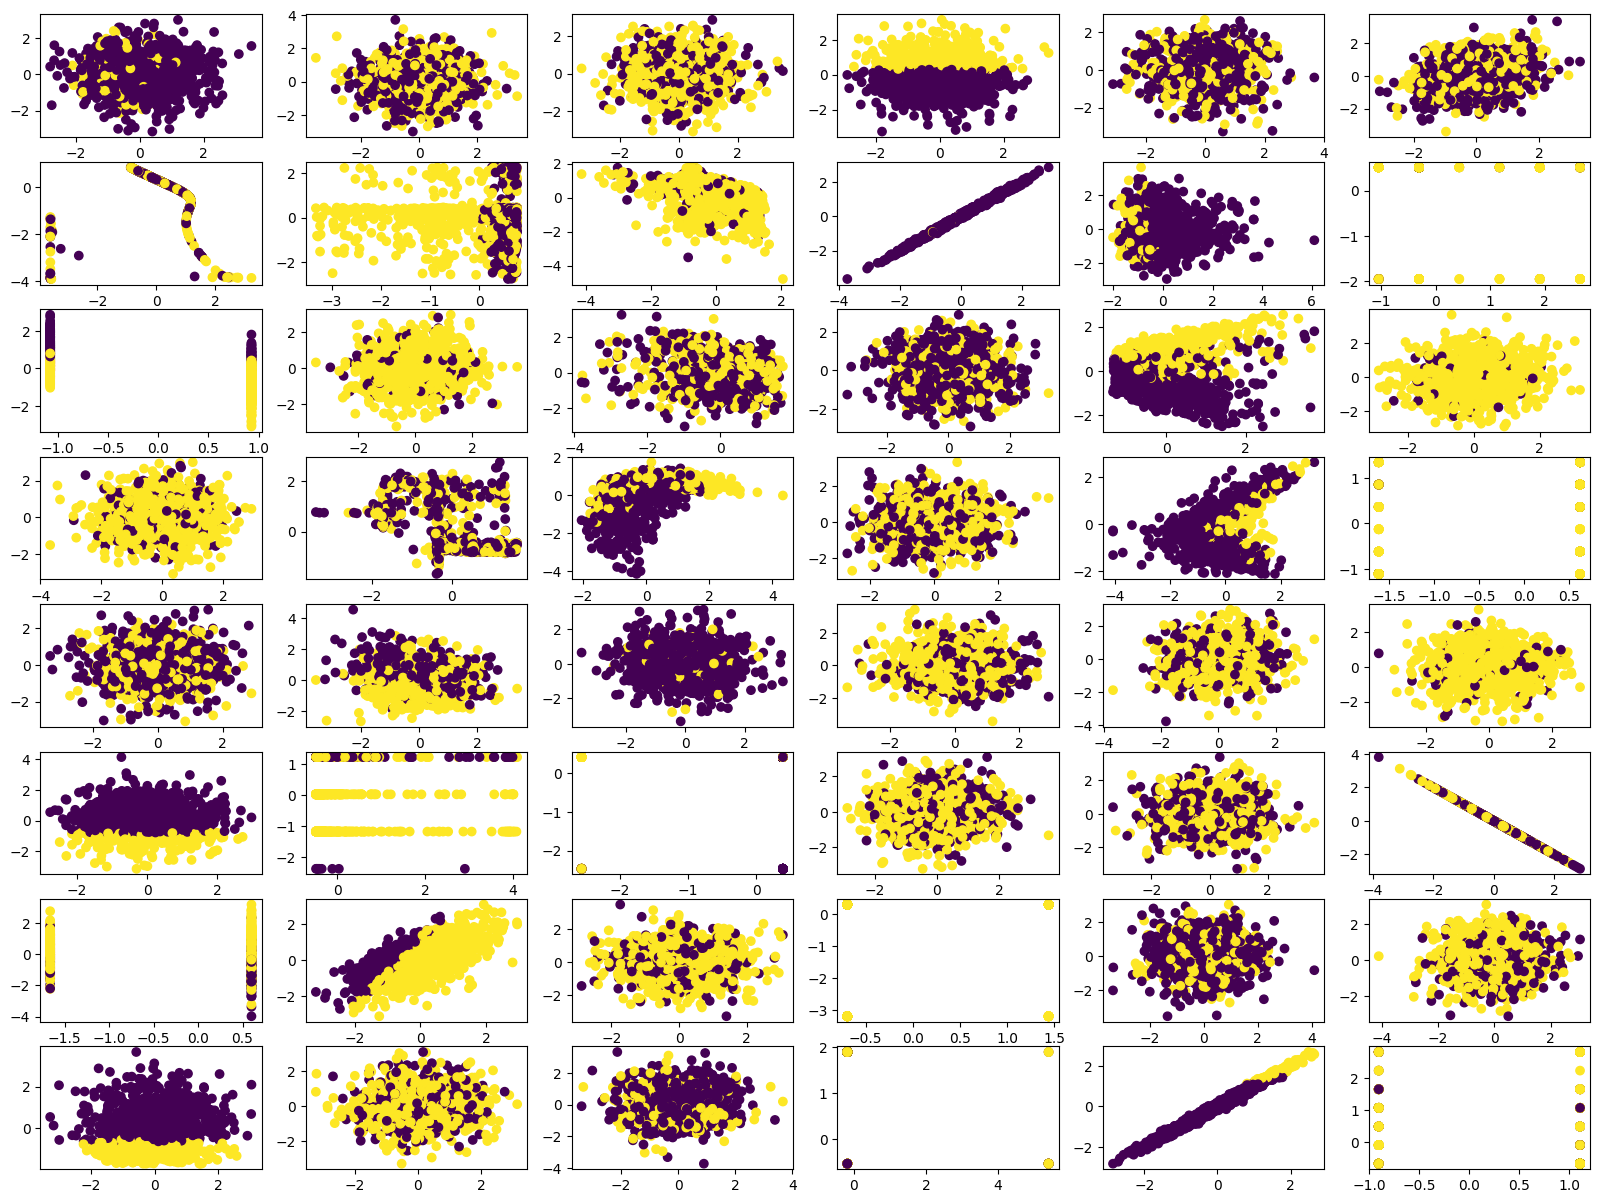

In [10]:
from tabularbench.data.synthetic_generator_tabpfn import synthetic_dataset_generator_tabpfn

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_tabpfn(n_samples=1000, max_classes=2, min_features=2, max_features=100)

for ax in axes.flatten():
    x2, b = next(generator)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    ax.scatter(x2[:, i1], x2[:, i2], c=b)

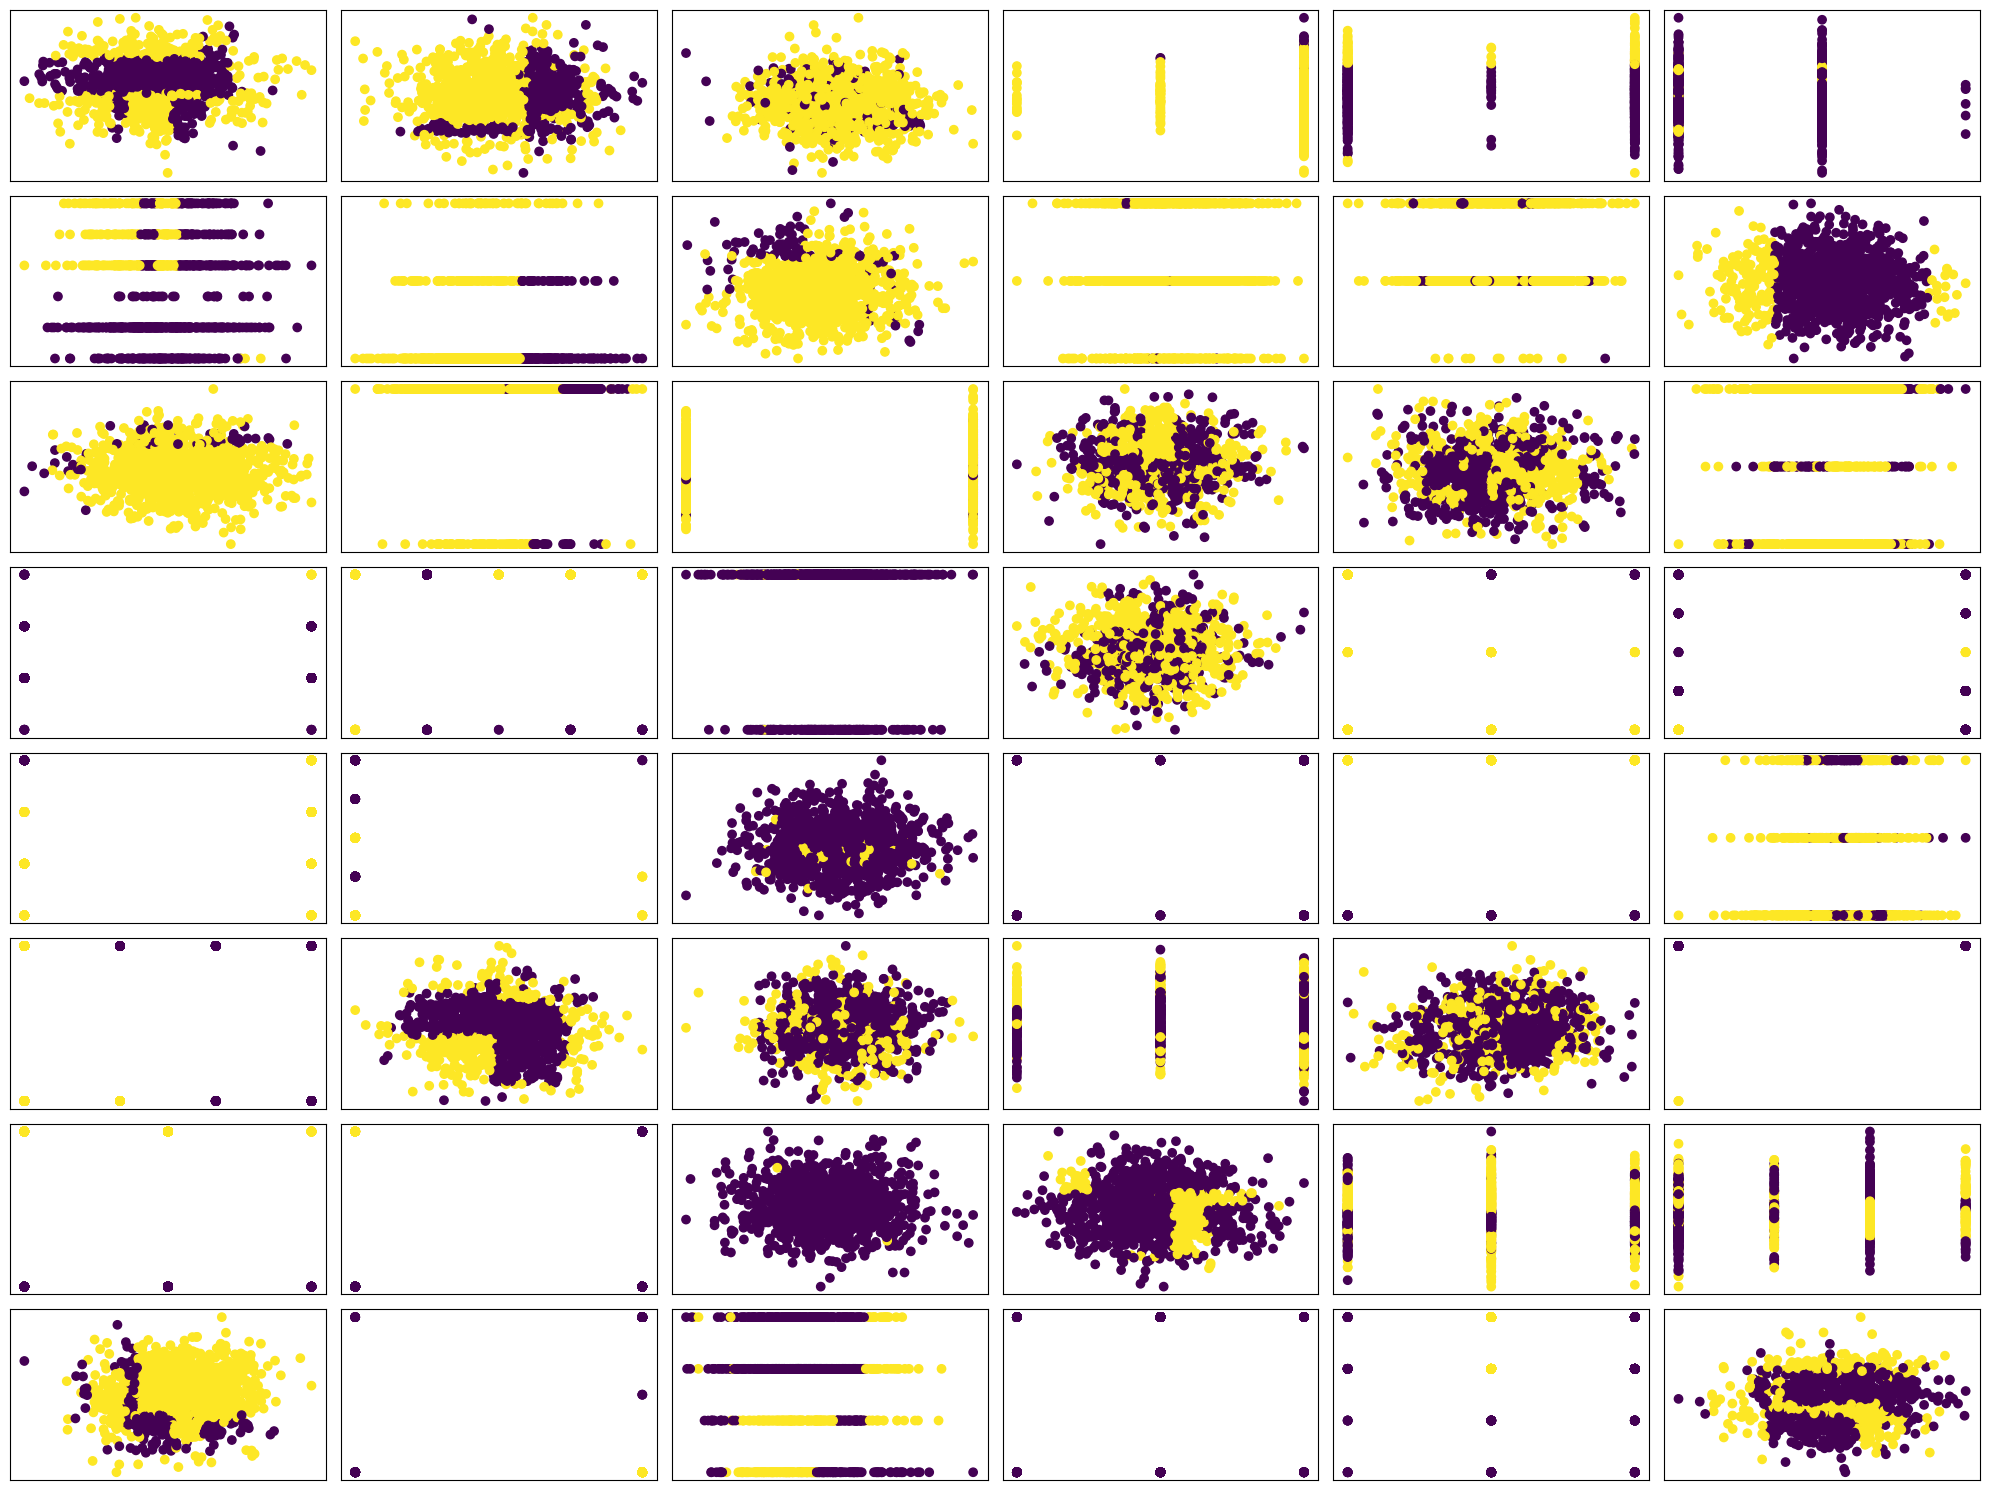

In [11]:
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest
import matplotlib

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_forest(n_samples=1000, max_classes=2, min_features=2, max_features=2)

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))

for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [12]:
def zinb(size=(1000,100)):
    pi = 0.25
    p = np.random.uniform(0.1,0.9, size=size[1])
    p = np.repeat(np.expand_dims(p,axis=0),size[0],axis=0)
    #print
    #p += 1e-5
    X = np.random.negative_binomial(100,p)
    X = np.random.binomial(1,1-pi,size)*X
    return X

In [13]:
def zinb_comp(size=(1000,100)):
    X =  zinb(size)
    print(X)
    print(np.expand_dims(1/np.sum(X,axis=1),axis=1))
    return np.expand_dims(1/np.sum(X,axis=1),axis=1)*X

In [14]:
out = zinb_comp((10,10))
print(out)

[[  0 413   0  25 558 231   0   0   0 198]
 [102 457  52  44 602   0   0   0  20 218]
 [ 91 413   0   0 676 231  42  17   0 184]
 [ 78   0  55  27 616   0   0   0   0 165]
 [ 93 431   0  26 594   0   0  15   0 173]
 [106   0   0  34 646 253  41  11   0 185]
 [ 96 431  59  32 565 241  43  26  16 165]
 [107 468  57   0   0 259   0  14  13 210]
 [ 90   0  43  33   0 285  31   0  17 139]
 [  0 436   0  19 511 365  32   0   0 183]]
[[0.00070175]
 [0.0006689 ]
 [0.00060459]
 [0.0010627 ]
 [0.00075075]
 [0.0007837 ]
 [0.00059737]
 [0.00088652]
 [0.0015674 ]
 [0.00064683]]
[[0.         0.28982456 0.         0.01754386 0.39157895 0.16210526
  0.         0.         0.         0.13894737]
 [0.06822742 0.30568562 0.03478261 0.02943144 0.40267559 0.
  0.         0.         0.01337793 0.1458194 ]
 [0.05501814 0.2496977  0.         0.         0.40870617 0.13966143
  0.02539299 0.01027811 0.         0.11124547]
 [0.08289054 0.         0.05844846 0.02869288 0.65462274 0.
  0.         0.         0.     

In [15]:
print(np.sum(out, axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


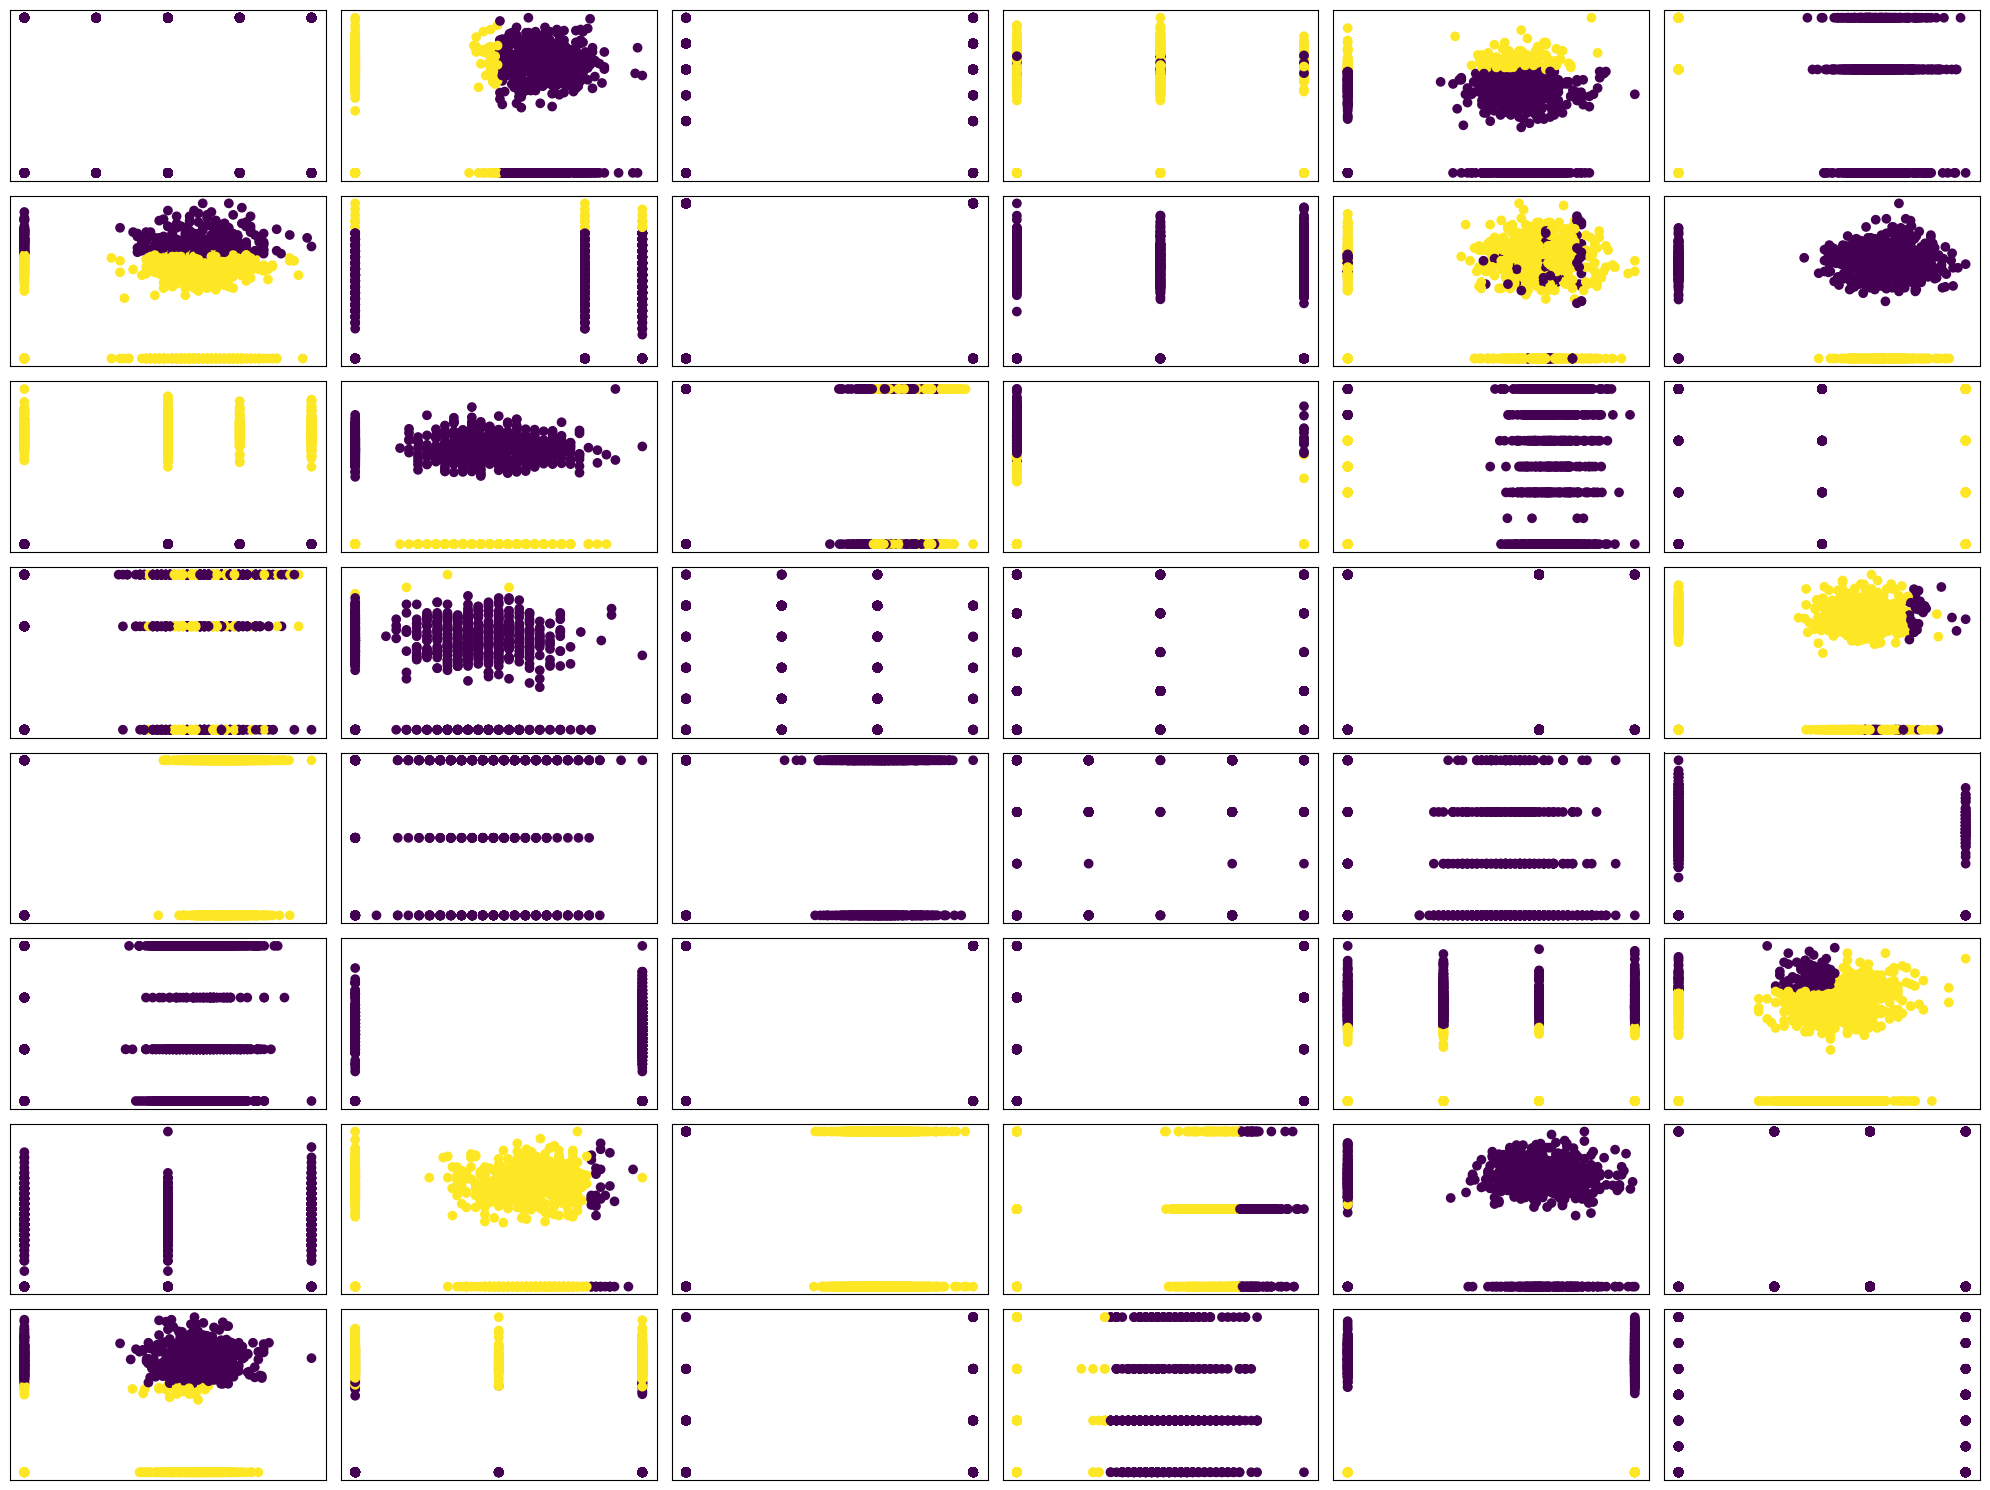

In [16]:
from prior.synthetic_generator_forest_altdata import synthetic_dataset_generator_forest_altdata, synthetic_dataset_function_forest_altdata

fig, axes = plt.subplots(8, 6, figsize=(20, 15))

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))



for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [17]:

X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

In [18]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_norm, b_norm, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)

C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    print(ii)
    X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_zinb, b_zinb, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)